# Lab 3: Gesture Recognition using Convolutional Neural Networks

**Deadlines**: 

Monday, June 13 at 5:00 PM (Part A)

Monday, July 04 at 5:00 PM (Part B)

**Late Penalty**: Any work that is submitted upto 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Grading TAs**: 
Geoff Donoghue --  <geoff.donoghue@mail.utoronto.ca>  

This lab is based on an assignment developed by Prof. Lisa Zhang.

This lab will be completed in two parts. In Part A you will gain experience gathering your own data set (specifically images of hand gestures), and understand the challenges involved in the data cleaning process. In Part B you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Generate and preprocess your own data
2. Load and split data for training, validation and testing
3. Train a Convolutional Neural Network
4. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

**Submission for Part A:**  
Submit a zip file containing your images. Three images each of American Sign Language gestures for letters A - I (total of 27 images). You will be required to clean the images before submitting them. Details are provided under Part A of the handout.

Individual image file names should follow the convention of student-number_Alphabet_file-number.jpg
(e.g. 100343434_A_1.jpg).


**Submission for Part B:**  
Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins. 

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1gIJEN_6ich8L-lxQ5B0SjeoNuJkDEcE5?usp=sharing

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)



---
I used the `Lab3_Gestures` data sets which is constructed with 9 folders which each contains 833-865 sets of image data (see figure for the detail class compositions). Considering the total dataset size is not relatively large, it would be ideal if most of the data is used for image training instead of model evaluations/ parameter tuning. Therefore, I decided to use a **70-15-15 percentage split** (70% of the total data goes to training set, 15% for both validation set and testing set).

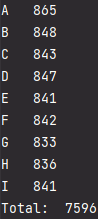

Next, I use the `ImageFolder` function for dataloading. The data spliting codes are shown below. This splitting strategy guaranteed that there exist unseen hands (from training process) in the testing set, and the data randomization for training set is aimed to improve the network's generalization capabilities in a realistic environment.



---





In [1]:
import os
import time
import torch
import numpy as np
import torch.nn as nn
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
def print_folder_structure(directory):
    """ Printing original structure of the folder
    and returns the number of images contained in each folder as a list.

    Args:
        directory: A string of home directory path that contains
                    the unzipped image data files
`
    Returns:
        count_list: A list of integers that are the number of images contained
                    in each class subfolder

    """
    total = 0
    count_list = []
    for folder in os.listdir(directory):
        count = 0
        f_path = os.path.join(directory, folder)
        for file in os.listdir(f_path):
            count += 1

        print(folder, " ", count)
        total += count
        count_list.append(count)

    print("Total: ", total)
    return count_list


def data_loader(data_folder, class_num, batch_size):
    """ Loads images data, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.
    Args:
        data_folder: torchvision.datasets.ImageFolder type that contains all datasets.
        class_num: A list contains number of sample sizes of each sign class
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size

    """
    train_indices, val_indices, test_indices = [], [], []
    count = 0
    for i in class_num:
        train_indices.extend(list(range(count, count + int(i * 0.7))))
        val_indices.extend(list(range(count + int(i * 0.7), count + int(i * 0.85))))
        test_indices.extend(list(range(count + int(i * 0.85), count + i)))
        # print(data_folder[i+count-1][1]) # for checking the end of each folder
        count += i

    np.random.seed(1000)
    np.random.shuffle(train_indices)

    train_sampler = SubsetRandomSampler(train_indices)
    train_loader_ = torch.utils.data.DataLoader(data_folder, batch_size=batch_size, num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader_ = torch.utils.data.DataLoader(data_folder, batch_size=batch_size, num_workers=1, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(test_indices)
    test_loader_ = torch.utils.data.DataLoader(data_folder, batch_size=batch_size, num_workers=1, sampler=test_sampler)

    return train_loader_, val_loader_, test_loader_


def data_visualizer(train_loader_, title):
    """ Loads images data loaders and plots the first 15 images of the data loader.
    This is for checking purpose.

    Args:
        train_loader_: iterable training dataset organized according to batch size
        title: string that is the title of the resulting plots
    """

    plt.figure()
    k = 0
    for images, labels in train_loader_:
        # since batch_size = 1, there is only 1 image in `images`
        image = images[0]
        # place the colour channel at the end, instead of at the beginning
        img = np.transpose(image, [1, 2, 0])
        # normalize pixel intensity values to [0, 1]
        img = img / 2 + 0.5
        plt.subplot(3, 5, k + 1)
        plt.suptitle(title)
        plt.axis('off')
        plt.imshow(img)

        k += 1
        if k > 14:
            break

A   865
B   848
C   843
D   847
E   841
F   842
G   833
H   836
I   841
Total:  7596


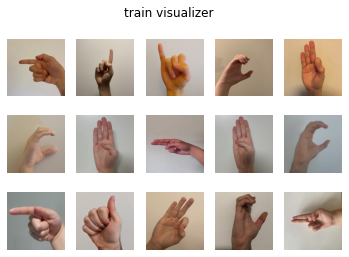

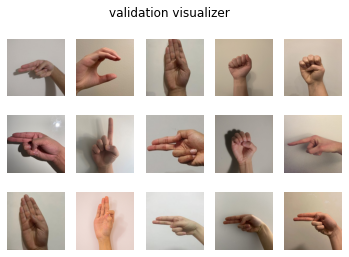

In [3]:
%matplotlib inline
# path to the root folder that contains all structures
# dir = "..."
directory = "C://Users//lindy//OneDrive//Documents//University//2.3.2rd_Year_Summer//APS360//lab//lab3//lab3_b//Lab3_Gestures"

# see original folder structure and get according number of image classes
count_l = print_folder_structure(directory)

# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(directory, transform=transform)

train_loader, val_loader, test_loader = data_loader(data_folder, count_l, 1)
data_visualizer(train_loader, "train visualizer")
data_visualizer(val_loader, "validation visualizer")

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?



---


This CNN architecture consists of two convolutional layer (first is 224*224*3 and the second one is 37*37*5) connected by two pooling layers (74*74*5, kernel size 2, stride 2 and 17*17*10, kernel size 2, stride 2) to reduce the computation time. Then the intermediate result is flattened as input to the two fully connected linear layers to produce the classification result. Activation function is Relu and hidden unit is 32.


---



In [4]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5,stride=3,padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5,stride=2,padding=0)
        self.pool2 = nn.MaxPool2d(stride=3, kernel_size=2)
        self.fc1 = nn.Linear(6* 6 * 10, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 6 * 10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice of loss function and optimizer.



---

I use SGD as my optimizer as it is a commonly used optimizer across the industry, while not having as strong adaptive ability as adam, SGD better generalizes than Adam as it has fix steps and thus less easily get stucked in local minimum (but converge slower)

Given the nature of this lab, a multiclassification problem, I chose crossentropyloss as my loss function as it minimizes the distance between the computed probability as well as the one-hot reality.

---



In [5]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


def train(model, train_loader,val_loader, batch_size=64, l_r=0.01, num_epochs=1):
    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=l_r, momentum=0.9)

    iters, epoch_itr, losses, val_loss, train_acc, val_acc = [], [], [], [], [], []

    # training
    n = 0 # the number of iterations

    progress_total = num_epochs * len(train_loader)
    pbar = tqdm(desc = 'while loop', total = progress_total)
    pbar.update(1)
    pbar.update(1)

    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)

            # compute *average* loss
            ###########################################
            # get_accuracy
            pred = out.max(1,keepdim = True)[1]
            correct = pred.eq(labels.view_as(pred)).sum().item()
            total = imgs.shape[0]
            t_acc = correct/ total
            # print(t_acc)
            train_acc.append(t_acc) # compute training accuracy

            #
            #
            # v_acc = get_accuracy(model, val_imgs,val_labels)
            # val_acc.append(v_acc)  # compute validation accuracy
            n += 1
            pbar.update(1)
            # print(n/progress_total*100, "% of the training is completed")
        ##################################################################
        val_l = 0
        correct = 0
        total = 0
        for valimgs, vallabels in val_loader:


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              valimgs = valimgs.cuda()
              vallabels = vallabels.cuda()
            #############################################

            output = model(valimgs)
            pred = output.max(1, keepdim=True)[1]
            val_l += criterion(output, vallabels).item()  # compute the total loss
            optimizer.zero_grad()
            correct += pred.eq(vallabels.view_as(pred)).sum().item()
            total += valimgs.shape[0]

        v_acc, v_loss = correct / total, float(val_l)/total
        ##################################################################
        val_acc.append(v_acc)  # compute validation accuracy
        val_loss.append(v_loss)
        epoch_itr.append(n)

        model_path = get_model_name(model.name, batch_size, l_r, epoch)
        # print(model_path)
        torch.save(model.state_dict(), model_path)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds\n".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.plot(epoch_itr, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(epoch_itr, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

**NOTE: here the training set is fed into the training process as the validation set for the ease of graphing, as no validation set is required for this sanity check exercise.**

#############################################
A   2
B   2
C   2
Total:  6
#############################################
CUDA is available!  Training on GPU ...



while loop:   0%|          | 0/30 [00:00<?, ?it/s]

Total time elapsed: 106.67 seconds



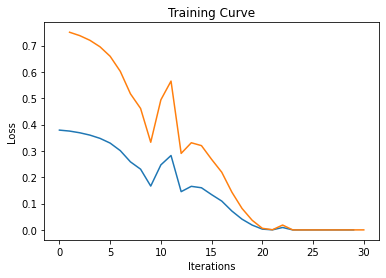

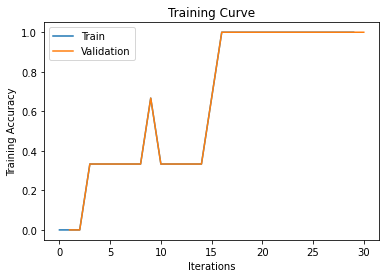

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [6]:
%matplotlib inline
# ======================================================
# path to the root folder that contains the sanity check images (2 for class A, 2 for class B, and 2 for class C)
# dir = "..."
directory = "C://Users//lindy//OneDrive//Documents//University//2.3.2rd_Year_Summer//APS360//lab//lab3//lab3_b//lab3_sanity_check"


# see original folder structure and get according number of image classes
print("#############################################")
count_l = print_folder_structure(directory)
print("#############################################")

# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(directory, transform=transform)

train_loader, val_loader, test_loader = data_loader(data_folder, count_l, 6)

use_cuda = True
model = LargeNet()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')

#proper model
train(model, train_loader, train_loader, l_r = 0.05, batch_size=6, num_epochs=30)


### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.



---



1.   Learning Rate (lr = 0.05 as default)
2.   Batch Size (batch_size = 64 as default)
3.   Channels of Convolutional Layer with/without dropout (LargeNet as default)



---



### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [28]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [29]:
# ======================================================
# path to the root folder
# dir = "..."
directory = "C://Users//lindy//OneDrive//Documents//University//2.3.2rd_Year_Summer//APS360//lab//lab3//lab3_b//Lab3_Gestures"
# see original folder structure and get according number of image classes
print("#############################################")
count_l = print_folder_structure(directory)
print("#############################################")
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def run_cnn(nn_model, bs = 64, num_e = 30, lr=0.05, cuda = True):

    data_folder = ImageFolder(directory, transform=transform)
    train_loader, val_loader, test_loader = data_loader(data_folder, count_l, batch_size=bs)
    if cuda and torch.cuda.is_available():
      nn_model.cuda()
      print('CUDA is available!  Training on GPU ...\n')
    else:
      print('CUDA is not available.  Training on CPU ...\n')
    #proper model
    train(nn_model, train_loader, val_loader, l_r = lr, batch_size=bs, num_epochs=num_e)

#############################################
A   865
B   848
C   843
D   847
E   841
F   842
G   833
H   836
I   841
Total:  7596
#############################################


CUDA is available!  Training on GPU ...



while loop:   0%|          | 0/2520 [00:00<?, ?it/s]

Total time elapsed: 604.01 seconds



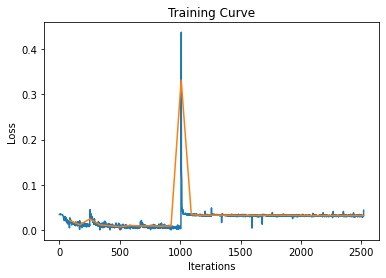

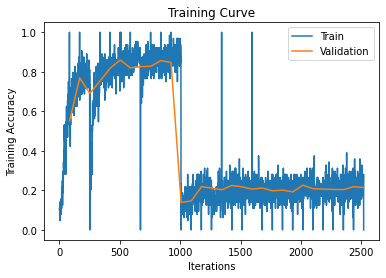

Final Training Accuracy: 0.0
Final Validation Accuracy: 0.21441124780316345


In [30]:
run_cnn(LargeNet())

CUDA is available!  Training on GPU ...



while loop:   0%|          | 0/2520 [00:00<?, ?it/s]

Total time elapsed: 506.87 seconds



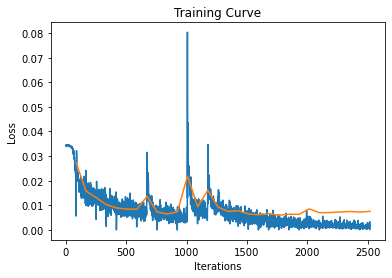

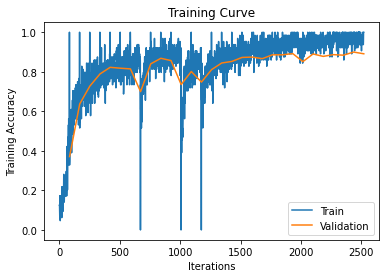

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8910369068541301


In [31]:
run_cnn(LargeNet(), bs = 64, num_e= 30, lr= 0.01)

CUDA is available!  Training on GPU ...



while loop:   0%|          | 0/1260 [00:00<?, ?it/s]

Total time elapsed: 475.48 seconds



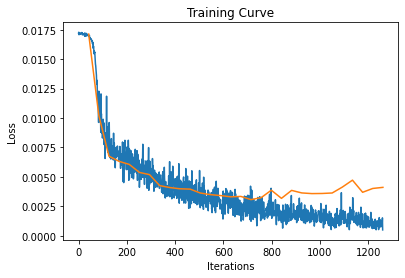

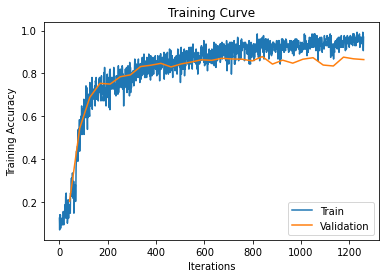

Final Training Accuracy: 0.9692307692307692
Final Validation Accuracy: 0.8646748681898067


In [32]:
run_cnn(LargeNet(), bs = 128, num_e= 30, lr= 0.01)

CUDA is available!  Training on GPU ...



while loop:   0%|          | 0/630 [00:00<?, ?it/s]

Total time elapsed: 452.30 seconds



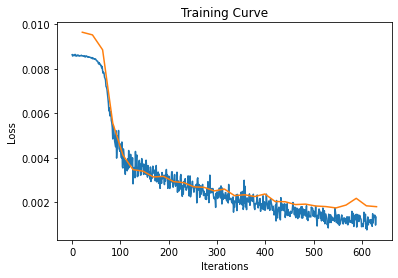

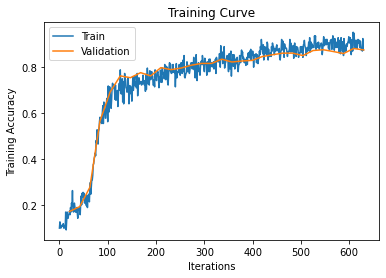

Final Training Accuracy: 0.8756476683937824
Final Validation Accuracy: 0.8760984182776801


In [33]:
run_cnn(LargeNet(), bs = 256, num_e= 30, lr= 0.01)

CUDA is available!  Training on GPU ...



while loop:   0%|          | 0/330 [00:00<?, ?it/s]

Total time elapsed: 447.69 seconds



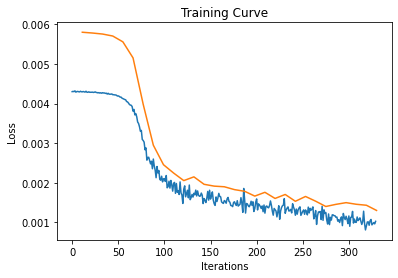

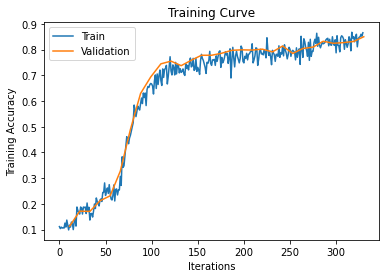

Final Training Accuracy: 0.8652849740932642
Final Validation Accuracy: 0.8497363796133568


In [34]:
run_cnn(LargeNet(), bs = 512, num_e= 30, lr= 0.01)

### Hyperparameter Setting: New Network with different convolutional layer dimension

In [35]:
class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.name = "newnet"
        self.conv1 = nn.Conv2d(3, 7, 5,stride=3,padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(7, 10, 5,stride=2,padding=0)
        self.pool2 = nn.MaxPool2d(stride=3, kernel_size=2)
        self.fc1 = nn.Linear(6* 6 * 10, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 6 * 10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [36]:
class NewNet_1(nn.Module):
    def __init__(self):
        super(NewNet_1, self).__init__()
        self.name = "newnet_1"
        self.conv1 = nn.Conv2d(3, 7, 5,stride=3,padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(7, 10, 5,stride=2,padding=0)
        self.pool2 = nn.MaxPool2d(stride=3, kernel_size=2)
        self.fc1 = nn.Linear(6* 6 * 10, 32)
        self.fc2 = nn.Linear(32, 9)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 6 * 10)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [37]:
class LargeNet_1(nn.Module):
    def __init__(self):
        super(LargeNet_1, self).__init__()
        self.name = "large_1"
        self.conv1 = nn.Conv2d(3, 5, 5,stride=3,padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5,stride=2,padding=0)
        self.pool2 = nn.MaxPool2d(stride=3, kernel_size=2)
        self.fc1 = nn.Linear(6* 6 * 10, 32)
        self.fc2 = nn.Linear(32, 9)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 6 * 10)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

CUDA is available!  Training on GPU ...



while loop:   0%|          | 0/1260 [00:00<?, ?it/s]

Total time elapsed: 434.68 seconds



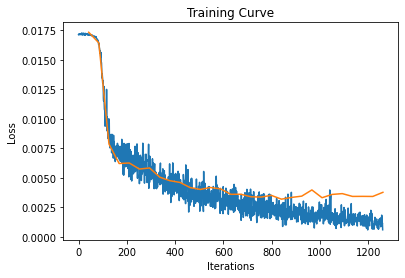

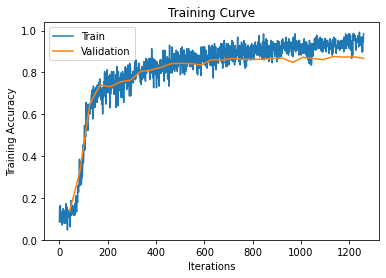

Final Training Accuracy: 0.9846153846153847
Final Validation Accuracy: 0.867311072056239


In [38]:
%matplotlib inline
run_cnn(NewNet(), bs = 128, num_e= 30, lr= 0.01)

CUDA is available!  Training on GPU ...



while loop:   0%|          | 0/1260 [00:00<?, ?it/s]

Total time elapsed: 433.18 seconds



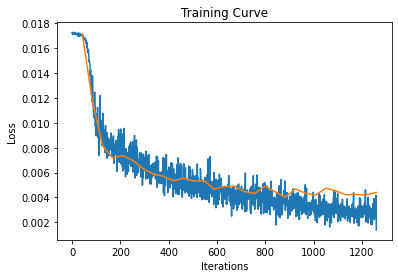

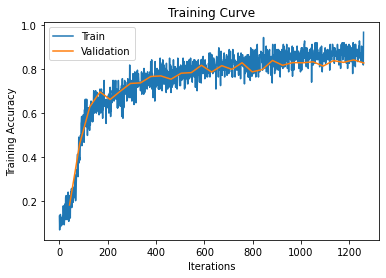

Final Training Accuracy: 0.9692307692307692
Final Validation Accuracy: 0.8295254833040422


In [39]:
%matplotlib inline
run_cnn(LargeNet_1(), bs = 128, num_e= 30, lr= 0.01)

CUDA is available!  Training on GPU ...



while loop:   0%|          | 0/1260 [00:00<?, ?it/s]

Total time elapsed: 438.98 seconds



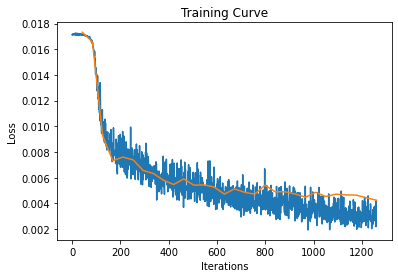

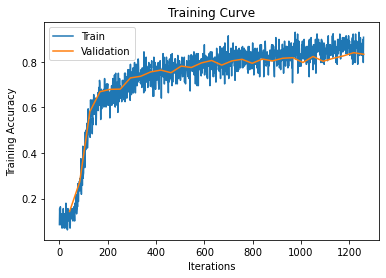

Final Training Accuracy: 0.9076923076923077
Final Validation Accuracy: 0.8330404217926186


In [40]:
%matplotlib inline
run_cnn(NewNet_1(), bs = 128, num_e= 30, lr= 0.01)

CUDA is available!  Training on GPU ...



while loop:   0%|          | 0/630 [00:00<?, ?it/s]

Total time elapsed: 445.93 seconds



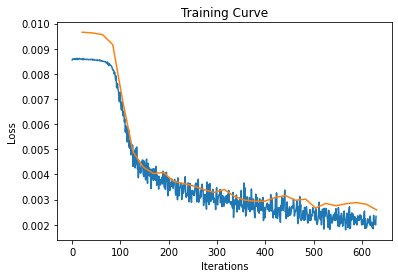

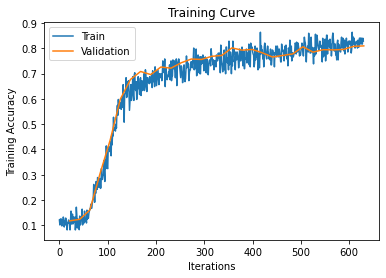

Final Training Accuracy: 0.8290155440414507
Final Validation Accuracy: 0.8093145869947276


In [41]:
%matplotlib inline
run_cnn(NewNet_1(), bs = 256, num_e= 30, lr= 0.01)

The best model is NewNet with batchsize of 128, learning rate of 0.01, and ran for 30 epoch. This is because it produces a 98% training accuracy (top 2 among all trials) with the highest validation accuracy of 88%. As we recognize that validation accuracy will produce a more realistic estimation of the model's actual performance, this model is chosen as the best model.

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [26]:
data_folder = ImageFolder(directory, transform=transform)
train_loader, val_loader, test_loader = data_loader(data_folder, count_l, batch_size=128)
net = NewNet()
net.load_state_dict(torch.load('model_newnet_bs128_lr0.01_epoch29'))

<All keys matched successfully>

In [27]:

correct = 0
total = 0
for testimgs, testlabels in test_loader:
    output = net(testimgs)
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(testlabels.view_as(pred)).sum().item()
    total += testimgs.shape[0]

test_acc = correct / total
print("The test accuracy for the best model is {}%".format(test_acc*100))

The test accuracy for the best model is 89.1703056768559%


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [18]:
import torchvision.models
from torchvision.models import AlexNet_Weights
alexnet = torchvision.models.alexnet(weights=AlexNet_Weights.DEFAULT)

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [19]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...

data_folder = ImageFolder(directory, transform=transform)
train_loader, val_loader, test_loader = data_loader(data_folder, count_l, batch_size=128)

alnc_feature = [[],[],[]]
loader_list = [train_loader, val_loader, test_loader]
for loader in range(len(loader_list)):
    for imgs, labels in loader_list[loader]:
        # alnc_feature[loader]
        feature = alexnet.features(imgs)
        alnc_feature[loader].append([torch.from_numpy(feature.detach().numpy()),labels])

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

I chose two fully-connected layers as the CNN network (and also provided a CNN model with two convolutional layer), this is because the output from alexnet is already small from dimension, thus having the two fully-connected layer will be enough to produce a satisfactory result.

In [148]:
# A CNN model for transfer learning
# class NewTLNet(nn.Module):
#     def __init__(self):
#         super(NewTLNet, self).__init__()
#         self.name = "newnet_tl"
#         self.conv1 = nn.Conv2d(256, 512, 3,stride=1,padding=0)
#         # self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(512, 1024, 3,stride=1,padding=0)
#         # self.pool2 = nn.MaxPool2d(stride=3, kernel_size=2)
#         self.fc1 = nn.Linear(2* 2 * 1024, 32)
#         self.fc2 = nn.Linear(32, 9)
#         self.dropout = nn.Dropout(0.50)
#     def forward(self, x):
#         # x = self.pool(F.relu(self.conv1(x)))
#         # x = self.pool2(F.relu(self.conv2(x)))
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         # print(x.size())
#         x = x.view(-1, 2* 2 * 1024)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

In [1]:
class InceptionBlock(nn.Module):
    def __init__(self):
        super(InceptionBlock, self).__init__()
        self.layer1 = nn.Conv2d(192, 64, 1)
        self.layer2 = nn.Conv2d(192, 96, 1)
        self.layer3 = nn.Conv2d(192, 16, 1)
        self.pool = nn.MaxPool2d(stride=1, kernel_size=3)
        self.layer4 = nn.Conv2d(96, 128, 3)
        self.layer5 = nn.Conv2d(16, 32, 5)
        self.layer6 = nn.Conv2d(192, 32, 1)

    def forward(self, x):
        # not drawning activation function on the diagram so it is skipped in the forward passing
        b_1 = self.layer1(x)
        b_2 = self.layer4(self.layer2(x))
        b_3 = self.layer5(self.layer3(x))
        b_4 = self.layer6(self.pool(x))
        x = b_1 + b_2 + b_3 + b_4
        return x



NameError: name 'nn' is not defined

In [22]:
class NewTLNet(nn.Module):
    def __init__(self):
        super(NewTLNet, self).__init__()
        self.name = "newnet_tl"
        self.fc1 = nn.Linear(6* 6 * 256, 128)
        self.fc2 = nn.Linear(128, 9)
    def forward(self, x):
        x = x.view(-1, 6* 6 * 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [20]:
def train_tl(model, alnc_feature, batch_size=64, l_r=0.01, num_epochs=1):
    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=l_r, momentum=0.9)

    iters, epoch_itr, losses, val_loss, train_acc, val_acc = [], [], [], [], [], []

    # training
    n = 0 # the number of iterations

    progress_total = num_epochs * len(alnc_feature[0])
    pbar = tqdm(desc = 'while loop', total = progress_total)
    start_time = time.time()
    for epoch in range(num_epochs):
        # feature_iter = iter(alnc_feature[0])
        # val_feature_iter = iter(alnc_feature[1])
        for imgs, labels in iter(alnc_feature[0]):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                # feature_iter = feature_iter.cuda()
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)

            # compute *average* loss
            ###########################################
            # get_accuracy
            pred = out.max(1,keepdim = True)[1]
            correct = pred.eq(labels.view_as(pred)).sum().item()
            total = imgs.shape[0]
            t_acc = correct/ total
            # print(t_acc)
            train_acc.append(t_acc) # compute training accuracy

            #
            #
            # v_acc = get_accuracy(model, val_imgs,val_labels)
            # val_acc.append(v_acc)  # compute validation accuracy
            n += 1
            pbar.update(1)
            # next(feature_iter)
            # print(n/progress_total*100, "% of the training is completed")
        ##################################################################
        val_l = 0
        correct = 0
        total = 0
        for valimgs, vallabels in alnc_feature[1]:


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                # val_feature_iter = val_feature_iter.cuda()
                valimgs = valimgs.cuda()
                vallabels = vallabels.cuda()
            #############################################

            output = model(valimgs)
            pred = output.max(1, keepdim=True)[1]
            val_l += criterion(output, vallabels).item()  # compute the total loss
            optimizer.zero_grad()
            correct += pred.eq(vallabels.view_as(pred)).sum().item()
            total += valimgs.shape[0]

        v_acc, v_loss = correct / total, float(val_l)/total
        ##################################################################
        val_acc.append(v_acc)  # compute validation accuracy
        val_loss.append(v_loss)
        epoch_itr.append(n)

        model_path = get_model_name(model.name, batch_size, l_r, epoch)
        # print(model_path)
        torch.save(model.state_dict(), model_path)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds\n".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.plot(epoch_itr, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(epoch_itr, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


CUDA is available!  Training on GPU ...



while loop:   0%|          | 0/1260 [00:00<?, ?it/s]

Total time elapsed: 4.70 seconds



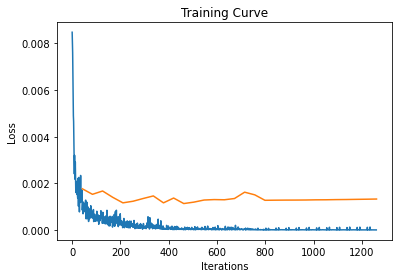

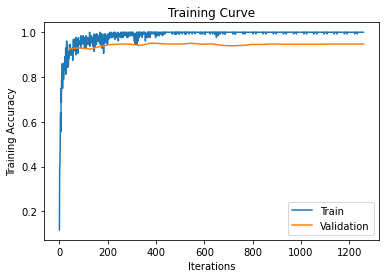

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9472759226713533


In [23]:
cuda = True
nn_model = NewTLNet()
lr = 0.01
bs = 256
num_e = 30

data_folder = ImageFolder(directory, transform=transform)
train_loader, val_loader, test_loader = data_loader(data_folder, count_l, batch_size=bs)
if cuda and torch.cuda.is_available():
    nn_model.cuda()
    print('CUDA is available!  Training on GPU ...\n')
else:
    print('CUDA is not available.  Training on CPU ...\n')
#proper model
train_tl(nn_model, alnc_feature, l_r = lr, batch_size=bs, num_epochs=num_e)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

This test accuracy(97.379912%) is much higher than the produced result from Part3(d) (89.1703)without transfer learning

In [24]:
data_folder = ImageFolder(directory, transform=transform)
train_loader, val_loader, test_loader = data_loader(data_folder, count_l, batch_size=256)
net = NewTLNet()
net.load_state_dict(torch.load('model_newnet_tl_bs256_lr0.01_epoch29'))

correct = 0
total = 0
for testimgs, testlabels in alnc_feature[2]:
    output = net(testimgs)
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(testlabels.view_as(pred)).sum().item()
    total += len(testimgs)

test_acc = correct / total
print("The test accuracy for the best model is {}%".format(test_acc*100))

The test accuracy for the best model is 97.117903930131%


### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures. 

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

The test accuracy is a perfect 100%, this means that this model performs well in every different hand gestures. However, as the test set is only consisted of 27 well-sampled images, this accuracy value is likely to be an overestimation of the actual performances of the model.

In [190]:
%matplotlib inline
# path to the root folder that contains all structures
# dir = "..."
directory = "C://Users//lindy//OneDrive//Documents//University//2.3.2rd_Year_Summer//APS360//lab//lab3//lab3_b//lab3_b"

# see original folder structure and get according number of image classes
count_l = print_folder_structure(directory)

# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(directory, transform=transform)

# train_loader, val_loader, test_loader = data_loader(data_folder, count_l, 1)
# data_visualizer(train_loader, "train visualizer")
# data_visualizer(val_loader, "validation visualizer")

test_loader = torch.utils.data.DataLoader(data_folder, batch_size=128, num_workers=1)
alnc_feature = []
for imgs, labels in test_loader:
    feature = alexnet.features(imgs)
    alnc_feature.append([torch.from_numpy(feature.detach().numpy()),labels])


correct = 0
total = 0
for testimgs, testlabels in alnc_feature:
    output = net(testimgs)
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(testlabels.view_as(pred)).sum().item()
    total += len(testimgs)

test_acc = correct / total
print("The test accuracy for the best model is {}%".format(test_acc*100))

A   3
B   3
C   3
D   3
E   3
F   3
G   3
H   3
I   3
Total:  27
The test accuracy for the best model is 100.0%
